In [2]:
# Cell 1: Install & imports
!pip install torch torchvision timm scikit-image --quiet

import os, glob, math, csv, random, time
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch.cuda.amp import autocast, GradScaler

from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [4]:
# Cell 2 (REPLACE): Dataset - create true LR (hr_size) and LR=(hr_size//scale)
from google.colab import drive
drive.mount('/content/drive')
import glob, random
from PIL import Image
from torchvision import transforms

train_dir = "/content/drive/MyDrive/Moon Kaggle Images/Training"   # set your paths
test_dir  = "/content/drive/MyDrive/Moon Kaggle Images/Testing"
hr_size = 256          # HR patch size
scale = 4              # SR scale factor (generator upsamples x4)
lr_size = hr_size // scale
batch_size = 4
num_workers = 2

def random_flip_rotate(img):
    if random.random() < 0.5: img = img.transpose(Image.FLIP_LEFT_RIGHT)
    if random.random() < 0.5: img = img.transpose(Image.FLIP_TOP_BOTTOM)
    return img

class SRDatasetCorrect(Dataset):
    def __init__(self, folder, hr_size=256, scale=4, augment=False):
        exts = ("*.png","*.jpg","*.jpeg")
        files = []
        for e in exts:
            files += glob.glob(os.path.join(folder, e))
        files = sorted(files)
        if len(files) == 0:
            raise ValueError(f"No images found in {folder}")
        self.files = files
        self.hr_size = hr_size
        self.scale = scale
        self.lr_size = hr_size // scale
        self.augment = augment
        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img = Image.open(self.files[idx]).convert("RGB")
        # make HR: crop/resize to exact HR size
        hr = img.resize((self.hr_size, self.hr_size), Image.BICUBIC)
        if self.augment:
            hr = random_flip_rotate(hr)
        # make LR by downscaling from HR (keep LR small, do NOT upscale it)
        lr = hr.resize((self.lr_size, self.lr_size), Image.BICUBIC)
        # return: lr (small), hr (big)
        return self.to_tensor(lr), self.to_tensor(hr)

# create datasets + loaders
train_ds = SRDatasetCorrect(train_dir, hr_size=hr_size, scale=scale, augment=True)
test_ds  = SRDatasetCorrect(test_dir,  hr_size=hr_size, scale=scale, augment=False)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=1, shuffle=False, num_workers=1, pin_memory=True)

print("Train images:", len(train_ds), "Test images:", len(test_ds))
print("HR size:", hr_size, "LR size:", lr_size, "Scale:", scale)


Mounted at /content/drive
Train images: 69 Test images: 4
HR size: 256 LR size: 64 Scale: 4


In [5]:
# Robust Discriminator replacement (simple, predictable output shape)
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, base_channels=64):
        super().__init__()
        def conv(in_c, out_c, stride=1, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 3, stride=stride, padding=1)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return nn.Sequential(*layers)

        c = base_channels
        self.block1 = conv(in_channels, c, stride=1, bn=False)   # 64
        self.block2 = conv(c, c, stride=2)                       # 64 -> down
        self.block3 = conv(c, c*2, stride=1)                     # 128
        self.block4 = conv(c*2, c*2, stride=2)
        self.block5 = conv(c*2, c*4, stride=1)
        self.block6 = conv(c*4, c*4, stride=2)
        self.block7 = conv(c*4, c*8, stride=1)
        self.block8 = conv(c*8, c*8, stride=2)

        # Global pooling -> flatten -> small MLP -> single logit
        self.gap = nn.AdaptiveAvgPool2d(1)   # always [B, C, 1, 1]
        self.fc = nn.Sequential(
            nn.Flatten(),                    # [B, C]
            nn.Linear(c*8, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1)               # final single logit per image
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.block6(x)
        x = self.block7(x)
        x = self.block8(x)
        x = self.gap(x)       # [B, C, 1, 1]
        x = self.fc(x)        # [B, 1]
        return x              # logits (not sigmoid)


In [6]:
# Cell 4: VGG feature extractor and loss functions
vgg = models.vgg19(pretrained=True).features[:36].to(device).eval()  # deep features for perceptual
for p in vgg.parameters(): p.requires_grad = False

mse_loss = nn.MSELoss()
l1_loss = nn.L1Loss()
bce_loss = nn.BCEWithLogitsLoss()  # use logits from discriminator; more stable

def vgg_loss(x, y):
    # x,y in [-1,1] -> convert to [0,1] for VGG normalization
    def to_vgg(inp):
        inp = (inp + 1.0) / 2.0
        mean = torch.tensor([0.485,0.456,0.406], device=inp.device).view(1,3,1,1)
        std  = torch.tensor([0.229,0.224,0.225], device=inp.device).view(1,3,1,1)
        return (inp - mean) / std
    fx = vgg(to_vgg(x))
    fy = vgg(to_vgg(y))
    return l1_loss(fx, fy)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:04<00:00, 138MB/s]


In [9]:
# Cell 5: Optimizers and hyperparameters

# Define the Generator class (missing from notebook)
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels),
            nn.PReLU(),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(channels)
        )

    def forward(self, x):
        return x + self.conv_block(x)

class Generator(nn.Module):
    def __init__(self, scale_factor=4, in_channels=3, num_res_blocks=16, base_channels=64):
        super(Generator, self).__init__()
        self.initial_block = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=9, stride=1, padding=4),
            nn.PReLU()
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(base_channels) for _ in range(num_res_blocks)]
        )
        self.mid_conv = nn.Sequential(
            nn.Conv2d(base_channels, base_channels, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(base_channels)
        )

        upsample_blocks = []
        for _ in range(int(math.log2(scale_factor))):
            upsample_blocks += [
                nn.Conv2d(base_channels, base_channels * 4, kernel_size=3, stride=1, padding=1),
                nn.PixelShuffle(2),
                nn.PReLU()
            ]
        self.upsampling = nn.Sequential(*upsample_blocks)

        self.final_conv = nn.Conv2d(base_channels, in_channels, kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        initial_features = self.initial_block(x)
        res_features = self.res_blocks(initial_features)
        mid_features = self.mid_conv(res_features) + initial_features # skip connection
        upsampled_features = self.upsampling(mid_features)
        out = self.final_conv(upsampled_features)
        return torch.tanh(out) # Output images in [-1, 1] range

# Instantiate the models (scale is defined in Cell 2)
generator = Generator(scale_factor=scale, in_channels=3, num_res_blocks=16, base_channels=64).to(device)
discriminator = Discriminator(in_channels=3, base_channels=64).to(device)

lr_G = 1e-4
lr_D = 1e-4
optimizer_G = optim.AdamW(generator.parameters(), lr=lr_G, betas=(0.9,0.999))
optimizer_D = optim.AdamW(discriminator.parameters(), lr=lr_D, betas=(0.9,0.999))
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.5)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.5)
scaler = GradScaler()

# loss weights - tuned for PSNR but keep adversarial (SRGAN)
w_l1 = 1.0          # strong content
w_vgg = 0.006       # perceptual
w_adv = 1e-3        # keep small so PSNR doesn't drop
print("Loss weights:", w_l1, w_vgg, w_adv)


Loss weights: 1.0 0.006 0.001


/tmp/ipython-input-3765740474.py:62: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [10]:
# Cell 6 (REPLACE): Robust SRGAN training loop - forces scalar logits [B,1]
epochs = 200
ckpt_dir = "/content/srgan_checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
best_psnr = -1.0

# two GradScalers for D and G (AMP-safe)
scaler_D = torch.cuda.amp.GradScaler()
scaler_G = torch.cuda.amp.GradScaler()

# helper: convert any discriminator output into shape [B,1] (scalar per sample)
def to_scalar_logits(tensor, batch_size):
    """
    Accepts tensor of shape:
      [B,1], [B,K], [B,C,H,W], [B,C,H], etc.
    Returns shape [B,1] by flattening per-sample and taking mean.
    """
    if tensor is None:
        return None
    # ensure tensor on correct device
    t = tensor
    # If already [B,1], return as-is (but ensure shape)
    if t.dim() == 2 and t.size(1) == 1:
        return t
    # else flatten everything except batch and take mean per sample
    flat = t.view(batch_size, -1)   # [B, N]
    mean_per_sample = flat.mean(dim=1, keepdim=True)  # [B,1]
    return mean_per_sample

for epoch in range(1, epochs+1):
    generator.train(); discriminator.train()
    running_G = 0.0; running_D = 0.0; steps = 0

    for lr_imgs, hr_imgs in train_loader:
        # move and scale to [-1,1] (generator uses tanh)
        lr_imgs = lr_imgs.to(device) * 2.0 - 1.0
        hr_imgs = hr_imgs.to(device) * 2.0 - 1.0
        bsz = lr_imgs.size(0)

        # ---------------- Train Discriminator ----------------
        optimizer_D.zero_grad()
        with autocast():
            fake_imgs = generator(lr_imgs).detach()      # detach for D update
            real_raw = discriminator(hr_imgs)            # could be many shapes
            fake_raw = discriminator(fake_imgs)

            real_logits = to_scalar_logits(real_raw, bsz)   # now [B,1]
            fake_logits = to_scalar_logits(fake_raw, bsz)   # now [B,1]

            # create targets with same shape and device
            real_targets = torch.ones_like(real_logits, device=real_logits.device, dtype=real_logits.dtype)
            fake_targets = torch.zeros_like(fake_logits, device=fake_logits.device, dtype=fake_logits.dtype)

            loss_real = bce_loss(real_logits, real_targets)
            loss_fake = bce_loss(fake_logits, fake_targets)
            loss_D = 0.5 * (loss_real + loss_fake)

        # AMP step for D (correct ordering)
        scaler_D.scale(loss_D).backward()
        scaler_D.unscale_(optimizer_D)
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
        scaler_D.step(optimizer_D)
        scaler_D.update()
        running_D += loss_D.item()

        # ---------------- Train Generator ----------------
        optimizer_G.zero_grad()
        with autocast():
            gen_imgs = generator(lr_imgs)
            # content losses
            loss_l1 = l1_loss(gen_imgs, hr_imgs)
            loss_vgg = vgg_loss(gen_imgs, hr_imgs)

            pred_raw = discriminator(gen_imgs)             # may have shape >=2 dims
            pred_logits = to_scalar_logits(pred_raw, bsz)   # [B,1]
            adv_targets = torch.ones_like(pred_logits, device=pred_logits.device, dtype=pred_logits.dtype)
            loss_adv = bce_loss(pred_logits, adv_targets)

            loss_G = w_l1 * loss_l1 + w_vgg * loss_vgg + w_adv * loss_adv

        # AMP step for G (correct ordering)
        scaler_G.scale(loss_G).backward()
        scaler_G.unscale_(optimizer_G)
        torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
        scaler_G.step(optimizer_G)
        scaler_G.update()
        running_G += loss_G.item()
        steps += 1

    # schedulers step
    scheduler_G.step(); scheduler_D.step()

    avg_G = running_G / max(1, steps)
    avg_D = running_D / max(1, steps)

    # ---- Validation ----
    generator.eval()
    psnrs = []; ssims = []
    with torch.no_grad():
        for vlr, vhr in test_loader:
            vlr = vlr.to(device) * 2.0 - 1.0
            vhr = vhr.to(device) * 2.0 - 1.0
            out = generator(vlr)
            out_np = ((out.cpu().permute(0,2,3,1).numpy() + 1)/2.0 * 255.0).clip(0,255).astype(np.uint8)
            hr_np  = ((vhr.cpu().permute(0,2,3,1).numpy() + 1)/2.0 * 255.0).clip(0,255).astype(np.uint8)
            for i in range(out_np.shape[0]):
                try:
                    p = compare_psnr(hr_np[i], out_np[i], data_range=255)
                except:
                    p = compare_psnr(hr_np[i][...,0], out_np[i][...,0], data_range=255)
                s = compare_ssim(hr_np[i], out_np[i], data_range=255, channel_axis=2)
                psnrs.append(p); ssims.append(s)

    mean_psnr = float(np.mean(psnrs)) if len(psnrs) else float('nan')
    mean_ssim = float(np.mean(ssims)) if len(ssims) else float('nan')

    # checkpoint best by PSNR
    if not math.isnan(mean_psnr) and mean_psnr > best_psnr:
        best_psnr = mean_psnr
        torch.save(generator.state_dict(), os.path.join(ckpt_dir, "best_generator.pth"))
        torch.save(discriminator.state_dict(), os.path.join(ckpt_dir, "best_discriminator.pth"))

    # log to csv
    with open(os.path.join(ckpt_dir,"log.csv"), "a", newline="") as f:
        csv.writer(f).writerow([epoch, avg_G, avg_D, mean_psnr, mean_ssim, best_psnr])

    print(f"Epoch {epoch}/{epochs} | G Loss: {avg_G:.6f} | D Loss: {avg_D:.6f} | Val PSNR: {mean_psnr:.3f} dB | Val SSIM: {mean_ssim:.4f} | Best PSNR: {best_psnr:.3f}")


/tmp/ipython-input-568438332.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = torch.cuda.amp.GradScaler()
/tmp/ipython-input-568438332.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = torch.cuda.amp.GradScaler()
/tmp/ipython-input-568438332.py:42: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/tmp/ipython-input-568438332.py:68: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/200 | G Loss: 0.275875 | D Loss: 0.626338 | Val PSNR: 19.727 dB | Val SSIM: 0.3399 | Best PSNR: 19.727
Epoch 2/200 | G Loss: 0.178586 | D Loss: 0.492878 | Val PSNR: 22.056 dB | Val SSIM: 0.4359 | Best PSNR: 22.056
Epoch 3/200 | G Loss: 0.167799 | D Loss: 0.409736 | Val PSNR: 21.661 dB | Val SSIM: 0.4581 | Best PSNR: 22.056
Epoch 4/200 | G Loss: 0.156340 | D Loss: 0.384827 | Val PSNR: 22.759 dB | Val SSIM: 0.5105 | Best PSNR: 22.759
Epoch 5/200 | G Loss: 0.150422 | D Loss: 0.312458 | Val PSNR: 22.895 dB | Val SSIM: 0.5231 | Best PSNR: 22.895
Epoch 6/200 | G Loss: 0.145248 | D Loss: 0.304600 | Val PSNR: 23.001 dB | Val SSIM: 0.5440 | Best PSNR: 23.001
Epoch 7/200 | G Loss: 0.141951 | D Loss: 0.395313 | Val PSNR: 24.088 dB | Val SSIM: 0.5534 | Best PSNR: 24.088
Epoch 8/200 | G Loss: 0.136706 | D Loss: 0.369446 | Val PSNR: 24.143 dB | Val SSIM: 0.5702 | Best PSNR: 24.143
Epoch 9/200 | G Loss: 0.128876 | D Loss: 0.209223 | Val PSNR: 24.342 dB | Val SSIM: 0.5809 | Best PSNR: 24.342
E

In [11]:
# Cell 7 (REPLACE): Robust final evaluation + save outputs
import os
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
import numpy as np
import matplotlib.pyplot as plt

out_dir = "/content/srgan_outputs"
os.makedirs(out_dir, exist_ok=True)

# if you saved a best checkpoint earlier, load it
best_gen_path = os.path.join(ckpt_dir, "best_generator.pth")
if os.path.exists(best_gen_path):
    try:
        generator.load_state_dict(torch.load(best_gen_path, map_location=device))
        print("Loaded best generator:", best_gen_path)
    except Exception as e:
        print("Could not load checkpoint:", e)

generator.eval()
psnrs = []
ssims = []

def to_uint8(img_tensor):
    # Accepts tensor in [-1,1] or [0,1] or float; returns uint8 HxWxC
    x = img_tensor
    if isinstance(x, torch.Tensor):
        x = x.detach().cpu().numpy()
    # now x: [C,H,W] or [B,C,H,W]
    if x.ndim == 4:
        x = x[0]
    # reorder to H,W,C
    x = np.transpose(x, (1,2,0))
    # if in [-1,1], convert
    if x.min() >= -1.1 and x.max() <= 1.1:
        x = (x + 1.0) / 2.0
    # clamp then to 0-255
    x = np.clip(x, 0.0, 1.0)
    x_u8 = (x * 255.0).round().astype(np.uint8)
    return x_u8

with torch.no_grad():
    idx = 0
    for lr, hr in test_loader:
        # lr: small (lr_size x lr_size), hr: big (hr_size x hr_size)
        lr = lr.to(device)
        hr = hr.to(device)

        # generate
        sr = generator(lr)
        # convert to uint8 images
        sr_u8 = to_uint8(sr)
        hr_u8 = to_uint8(hr)
        # If shapes mismatch (rare), center-crop larger to match smaller
        if sr_u8.shape != hr_u8.shape:
            # match smallest dims
            h_min = min(sr_u8.shape[0], hr_u8.shape[0])
            w_min = min(sr_u8.shape[1], hr_u8.shape[1])
            sr_u8 = sr_u8[:h_min, :w_min, ...]
            hr_u8 = hr_u8[:h_min, :w_min, ...]
        # save sr image
        save_path = os.path.join(out_dir, f"sr_{idx}.png")
        plt.imsave(save_path, sr_u8)
        # compute metrics (handle grayscale or RGB)
        try:
            p = compare_psnr(hr_u8, sr_u8, data_range=255)
        except Exception:
            # fallback to single-channel comparison
            p = compare_psnr(hr_u8[...,0], sr_u8[...,0], data_range=255)
        try:
            s = compare_ssim(hr_u8, sr_u8, data_range=255, channel_axis=2)
        except Exception:
            s = compare_ssim(hr_u8[...,0], sr_u8[...,0], data_range=255)
        psnrs.append(p); ssims.append(s)
        idx += 1

# final metrics
final_psnr = float(np.mean(psnrs)) if len(psnrs) else float('nan')
final_ssim = float(np.mean(ssims)) if len(ssims) else float('nan')

print("===== FINAL METRICS =====")
print(f"Final Mean PSNR: {final_psnr:.3f} dB")
print(f"Final Mean SSIM: {final_ssim:.4f}")
print("Saved SR images to:", out_dir)


Loaded best generator: /content/srgan_checkpoints/best_generator.pth
===== FINAL METRICS =====
Final Mean PSNR: 29.772 dB
Final Mean SSIM: 0.7375
Saved SR images to: /content/srgan_outputs


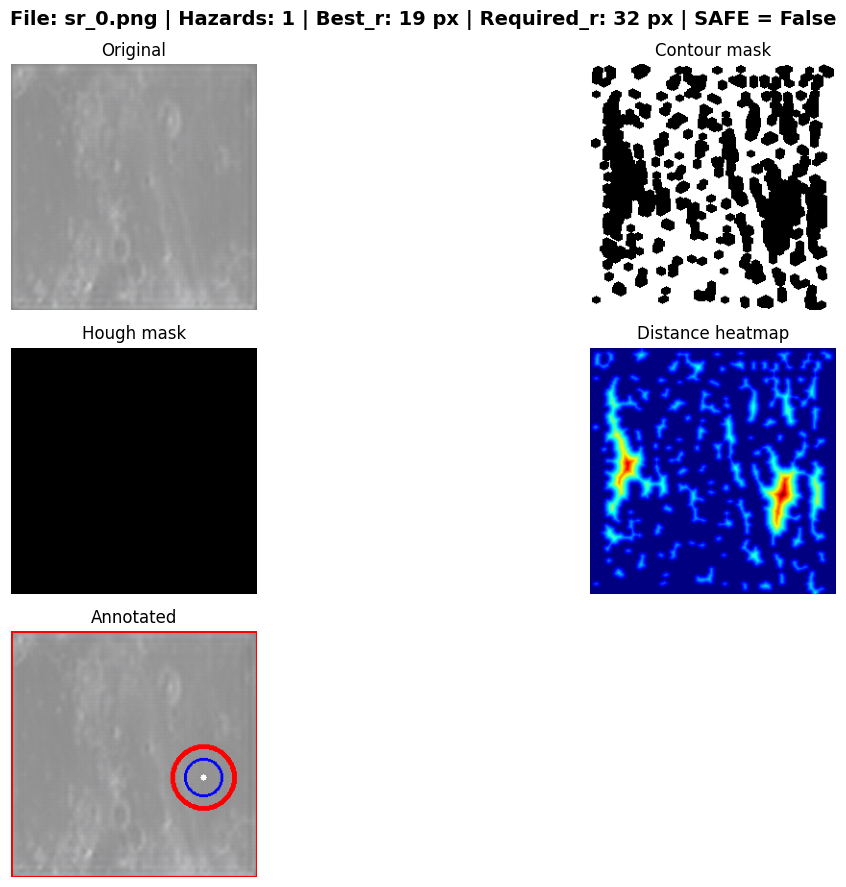

File: sr_0.png | Hazards: 1 | Best_r: 19 px | Required_r: 32 px | SAFE = False | saved -> /content/annotated_outputs_final2/sr_0.png


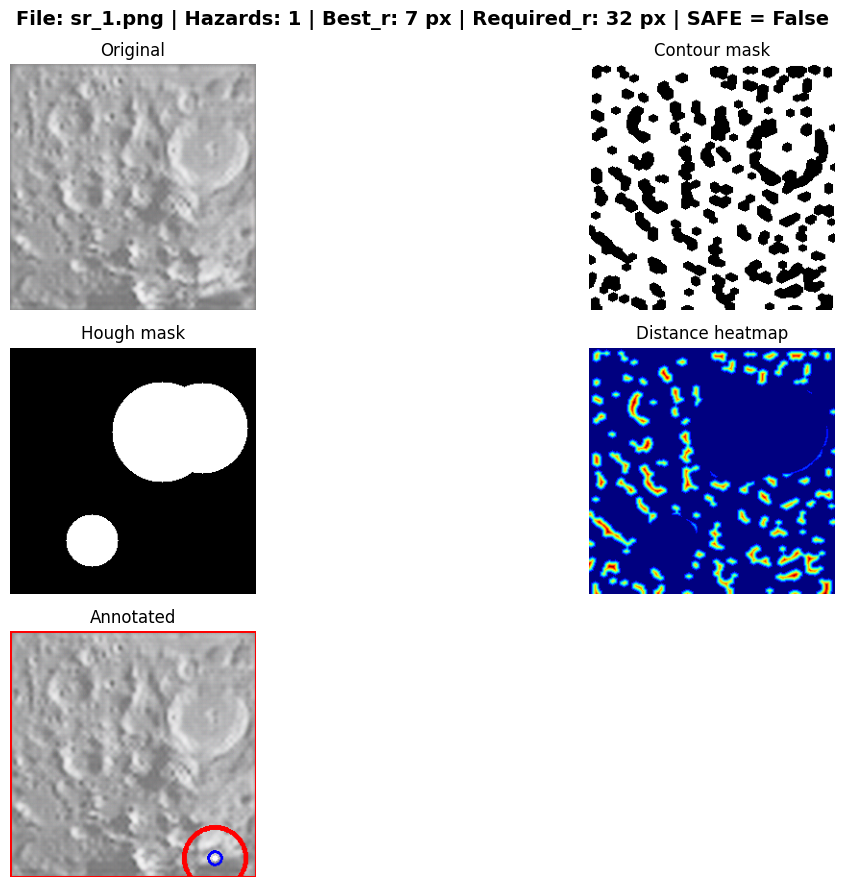

File: sr_1.png | Hazards: 1 | Best_r: 7 px | Required_r: 32 px | SAFE = False | saved -> /content/annotated_outputs_final2/sr_1.png


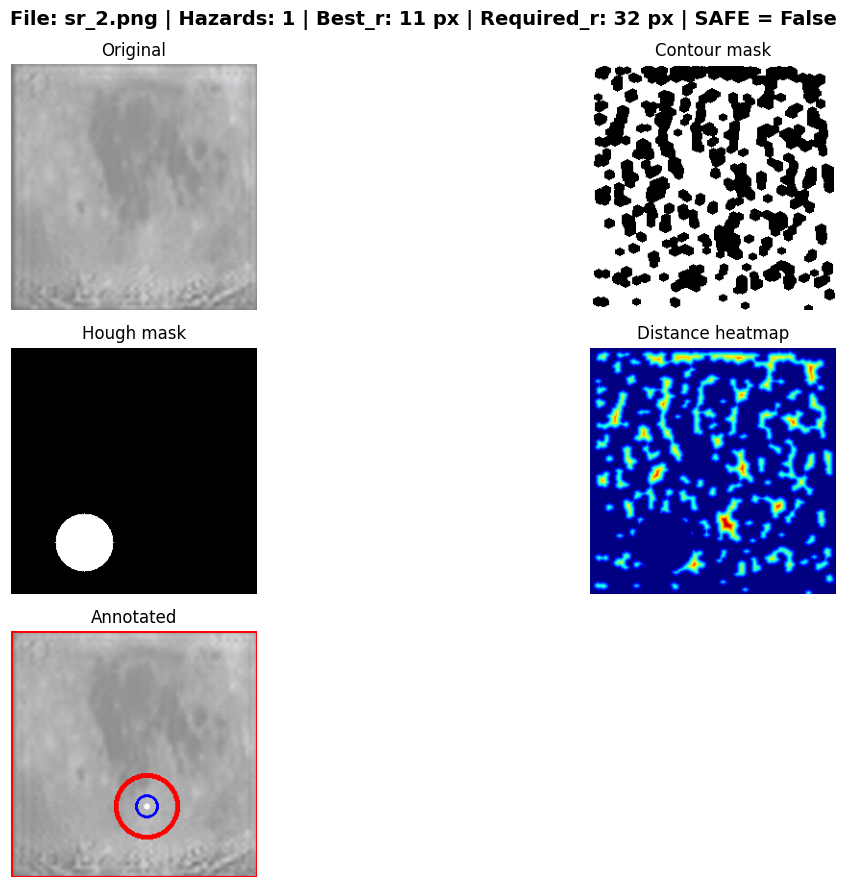

File: sr_2.png | Hazards: 1 | Best_r: 11 px | Required_r: 32 px | SAFE = False | saved -> /content/annotated_outputs_final2/sr_2.png


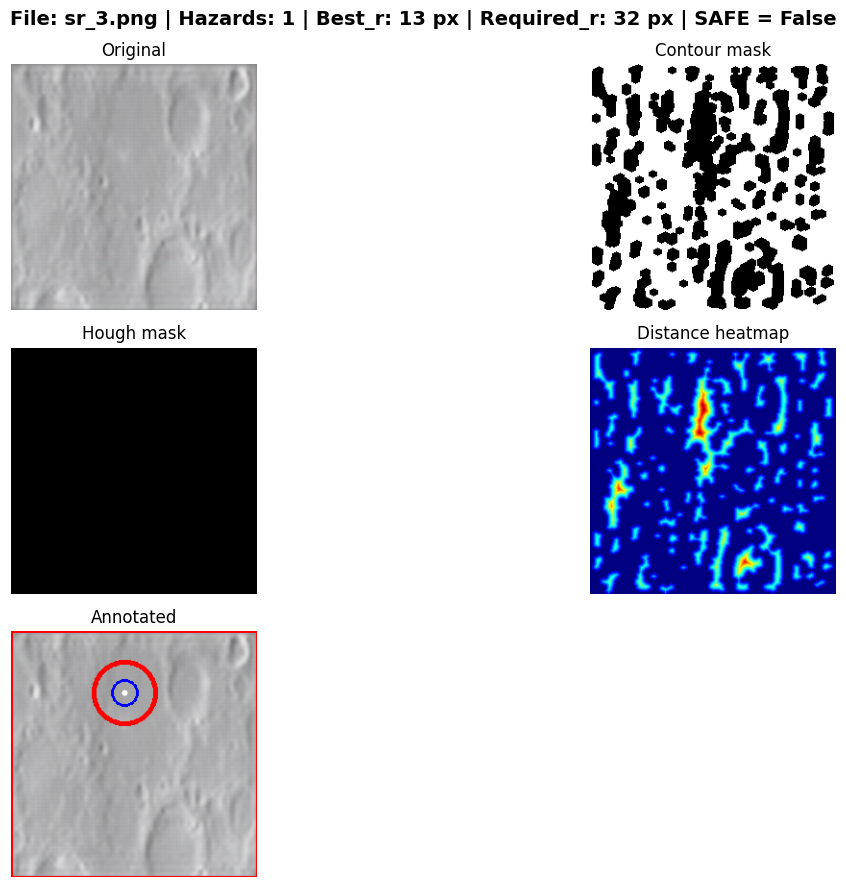

File: sr_3.png | Hazards: 1 | Best_r: 13 px | Required_r: 32 px | SAFE = False | saved -> /content/annotated_outputs_final2/sr_3.png

Done — All outputs saved in: /content/annotated_outputs_final2


In [12]:
# REPLACEMENT cell — cleaned pipeline + HEADER TEXT above each output
import os, cv2, numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, exposure

# Paths
src_dir = "/content/srgan_outputs"
out_dir = "/content/annotated_outputs_final2"
os.makedirs(out_dir, exist_ok=True)

# ---------- TUNE THESE ----------
min_hazard_area = 800
landing_radius_px = 32

hough_dp = 1.2
hough_minDist = 30
hough_param1 = 100
hough_param2 = 60
hough_minRadius = 10
hough_maxRadius = 60

hough_overlap_iou_thresh = 0.12
border_ignore = 6
# -------------------------------

def show_grid(images, titles=None, header_text="", figsize=(13,9)):
    plt.figure(figsize=figsize)
    plt.suptitle(header_text, fontsize=14, fontweight='bold')

    n = len(images)
    cols = 2
    rows = (n + cols - 1) // cols

    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def detect_and_filter(img_bgr):
    h, w = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_eq = exposure.equalize_adapthist(gray, clip_limit=0.03)
    gray_eq = (gray_eq * 255).astype(np.uint8)
    blur = cv2.GaussianBlur(gray_eq, (5,5), 0)

    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 31, 9)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    th_closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    th_bool = th_closed.astype(bool)
    th_clean = morphology.remove_small_objects(th_bool, min_size=min_hazard_area)
    mask_contour = (th_clean.astype('uint8') * 255)

    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=hough_dp,
                               minDist=hough_minDist,
                               param1=hough_param1,
                               param2=hough_param2,
                               minRadius=hough_minRadius,
                               maxRadius=hough_maxRadius)

    mask_hough = np.zeros((h,w), dtype=np.uint8)
    accepted_hough = []

    if circles is not None:
        circles = np.round(circles[0,:]).astype(int)
        circles = sorted(circles.tolist(), key=lambda x: -x[2])

        for (cx, cy, r) in circles:
            if cx < border_ignore or cy < border_ignore or cx > w-border_ignore or cy > h-border_ignore:
                continue
            if r < hough_minRadius or r > hough_maxRadius:
                continue

            circ_mask = np.zeros((h,w), dtype=np.uint8)
            rr = max(1, r-2)
            cv2.circle(circ_mask, (cx,cy), rr, 255, -1)

            inter = np.logical_and(circ_mask>0, mask_contour>0).sum()
            circ_area = circ_mask.sum() / 255.0
            if circ_area == 0:
                continue

            overlap = inter / circ_area
            if overlap >= hough_overlap_iou_thresh:
                accepted_hough.append((cx,cy,r,overlap))
                cv2.circle(mask_hough, (cx,cy), rr, 255, -1)

    combined = cv2.bitwise_or(mask_contour, mask_hough)
    comb_bool = combined.astype(bool)
    comb_clean = morphology.remove_small_objects(comb_bool, min_size=min_hazard_area)
    final_mask = (comb_clean.astype('uint8') * 255)

    return mask_contour, mask_hough, final_mask, accepted_hough


def find_landing(mask, required_radius):
    h, w = mask.shape[:2]
    if np.sum(mask) == 0:
        return h//2, w//2, min(h,w)//3, True

    free = (mask == 0).astype(np.uint8)
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)

    ys, xs = np.where(dist >= required_radius)

    if len(ys) > 0:
        best_idx = np.argmax(dist[ys, xs])
        cy, cx = int(ys[best_idx]), int(xs[best_idx])
        return cy, cx, int(dist[cy,cx]), True

    _, maxVal, _, maxLoc = cv2.minMaxLoc(dist)
    cy, cx = maxLoc[1], maxLoc[0]
    best_r = int(maxVal)
    best_r = min(best_r, min(h//2, w//2))
    return cy, cx, best_r, False


# ----------------- RUN PIPELINE -------------------

for fname in sorted(os.listdir(src_dir)):
    if not fname.lower().endswith((".png",".jpg",".jpeg")):
        continue

    path = os.path.join(src_dir, fname)
    img = cv2.imread(path)
    if img is None:
        continue

    h, w = img.shape[:2]

    mask_contour, mask_hough, mask_final, accepted_hough = detect_and_filter(img)
    cy, cx, best_r, is_safe = find_landing(mask_final, landing_radius_px)

    contours, _ = cv2.findContours(mask_final.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    hazard_count = 0
    out = img.copy()

    for c in contours:
        area = cv2.contourArea(c)
        if area < min_hazard_area:
            continue
        hazard_count += 1
        x,y,ww,hh = cv2.boundingRect(c)
        cv2.rectangle(out, (x,y), (x+ww,y+hh), (0,0,255), 2)

    # draw circles
    br = max(1, min(best_r, min(h//2, w//2)))
    color_required = (0,255,0) if is_safe else (0,0,255)

    cv2.circle(out, (cx,cy), br, (255,0,0), 2)
    cv2.circle(out, (cx,cy), landing_radius_px, color_required, 3)
    cv2.circle(out, (cx,cy), 3, (255,255,255), -1)

    # ---------- ADDED HEADER TEXT ----------
    header = (
        f"File: {fname} | Hazards: {hazard_count} | "
        f"Best_r: {best_r} px | Required_r: {landing_radius_px} px | "
        f"SAFE = {is_safe}"
    )
    # ---------------------------------------

    # dist map
    free = (mask_final == 0).astype(np.uint8)
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)
    if dist.max() > 0:
        dv = (dist / dist.max() * 255).astype(np.uint8)
    else:
        dv = dist.astype(np.uint8)
    dist_color = cv2.applyColorMap(dv, cv2.COLORMAP_JET)

    save_path = os.path.join(out_dir, fname)
    cv2.imwrite(save_path, out)

    # show everything with HEADER TEXT
    show_grid(
        [
            cv2.cvtColor(img, cv2.COLOR_BGR2RGB),
            cv2.cvtColor(mask_contour, cv2.COLOR_GRAY2RGB),
            cv2.cvtColor(mask_hough, cv2.COLOR_GRAY2RGB),
            cv2.cvtColor(dist_color, cv2.COLOR_BGR2RGB),
            cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
        ],
        titles=["Original", "Contour mask", "Hough mask", "Distance heatmap", "Annotated"],
        header_text=header
    )

    print(header, "| saved ->", save_path)

print("\nDone — All outputs saved in:", out_dir)



--- Results using meters_per_pixel = 0.005 m/px -> required_radius = 220 px ---



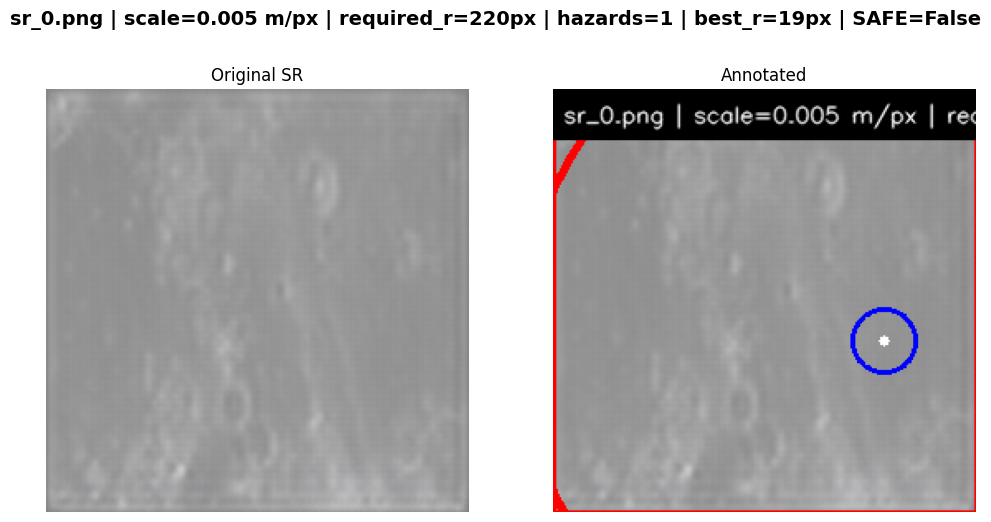

sr_0.png | scale=0.005 m/px | required_r=220px | hazards=1 | best_r=19px | SAFE=False


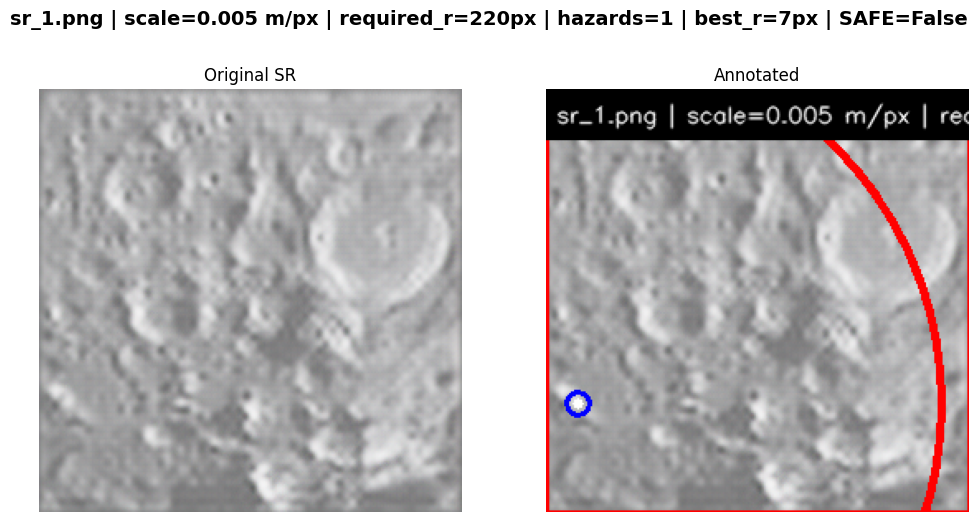

sr_1.png | scale=0.005 m/px | required_r=220px | hazards=1 | best_r=7px | SAFE=False


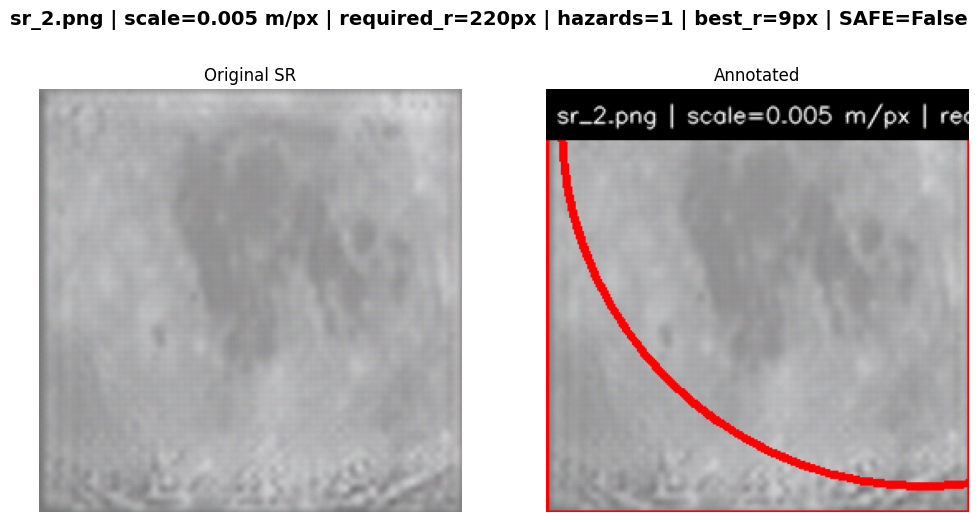

sr_2.png | scale=0.005 m/px | required_r=220px | hazards=1 | best_r=9px | SAFE=False


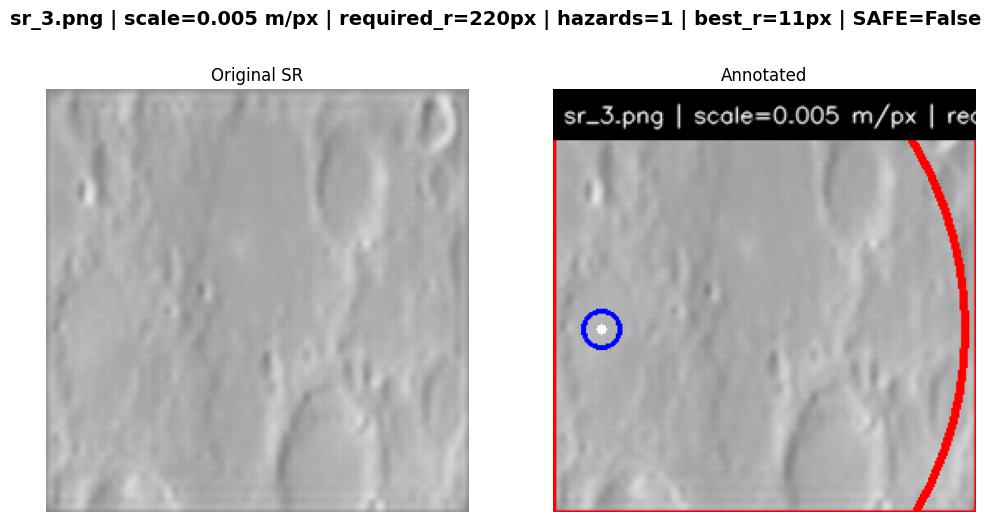

sr_3.png | scale=0.005 m/px | required_r=220px | hazards=1 | best_r=11px | SAFE=False

--- Results using meters_per_pixel = 0.01 m/px -> required_radius = 110 px ---



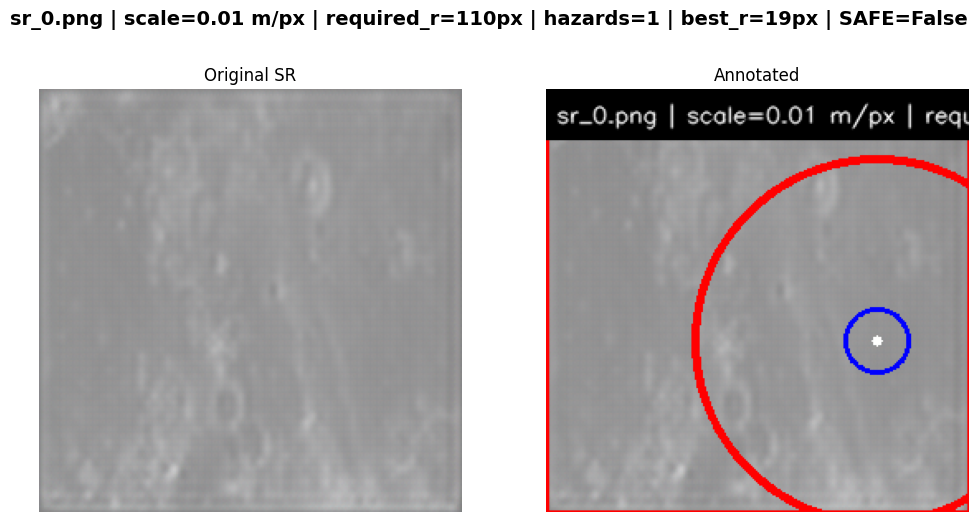

sr_0.png | scale=0.01 m/px | required_r=110px | hazards=1 | best_r=19px | SAFE=False


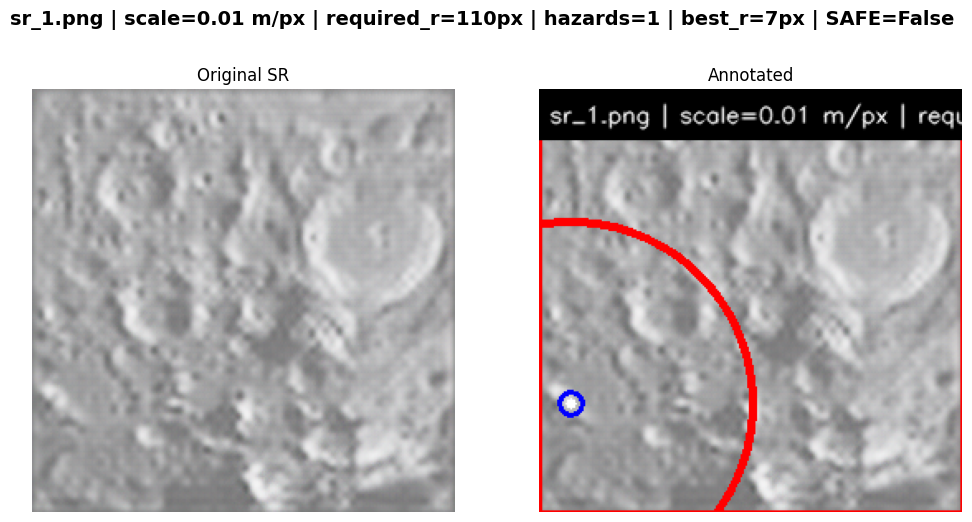

sr_1.png | scale=0.01 m/px | required_r=110px | hazards=1 | best_r=7px | SAFE=False


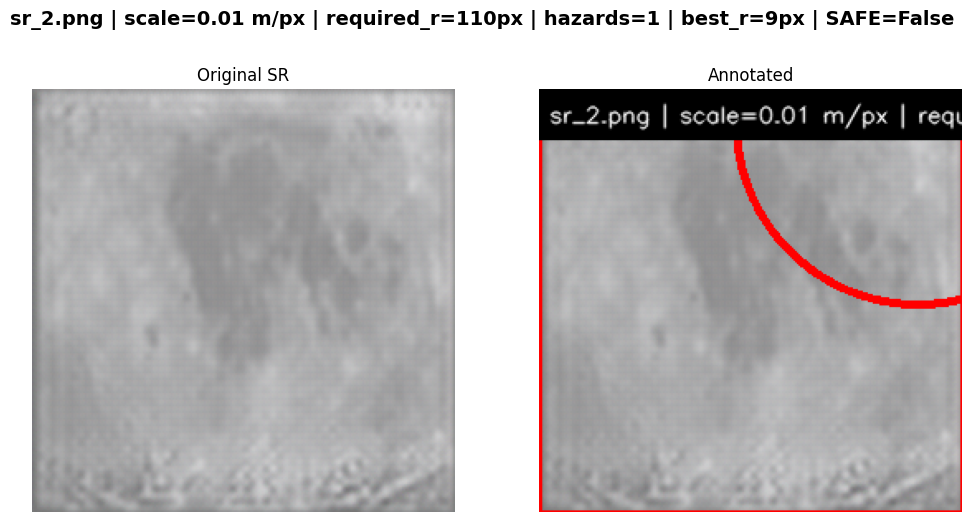

sr_2.png | scale=0.01 m/px | required_r=110px | hazards=1 | best_r=9px | SAFE=False


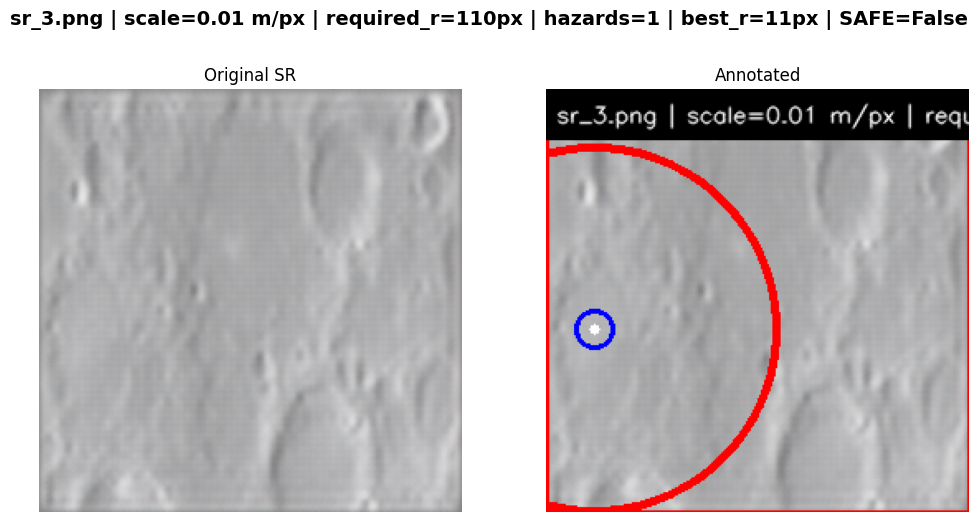

sr_3.png | scale=0.01 m/px | required_r=110px | hazards=1 | best_r=11px | SAFE=False

--- Results using meters_per_pixel = 0.02 m/px -> required_radius = 55 px ---



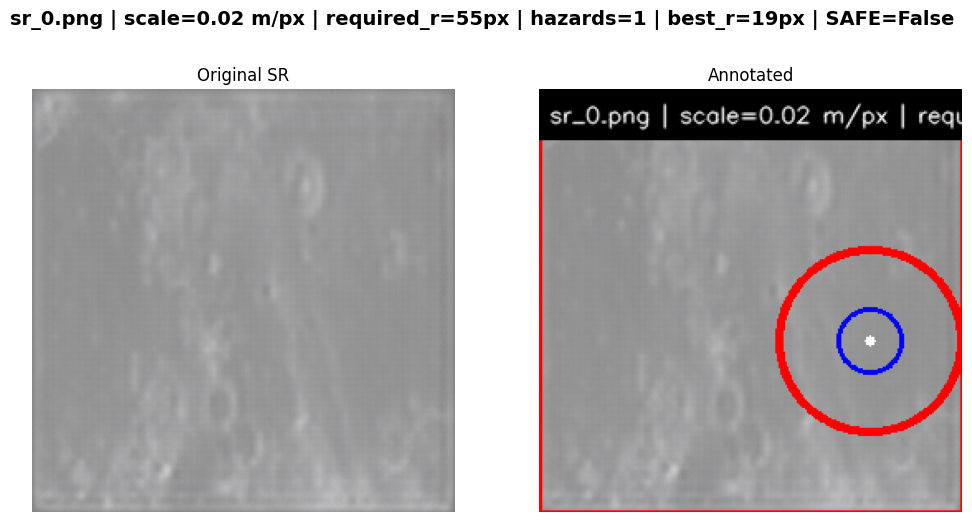

sr_0.png | scale=0.02 m/px | required_r=55px | hazards=1 | best_r=19px | SAFE=False


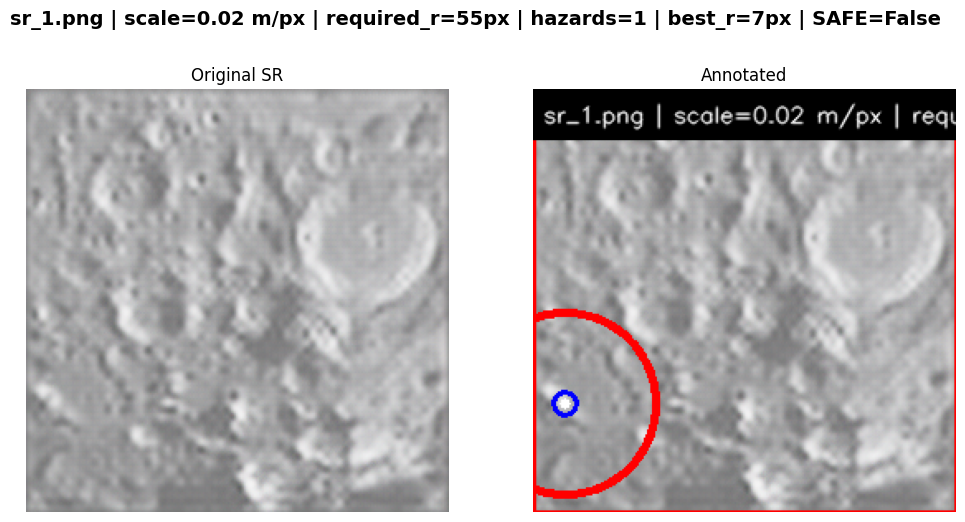

sr_1.png | scale=0.02 m/px | required_r=55px | hazards=1 | best_r=7px | SAFE=False


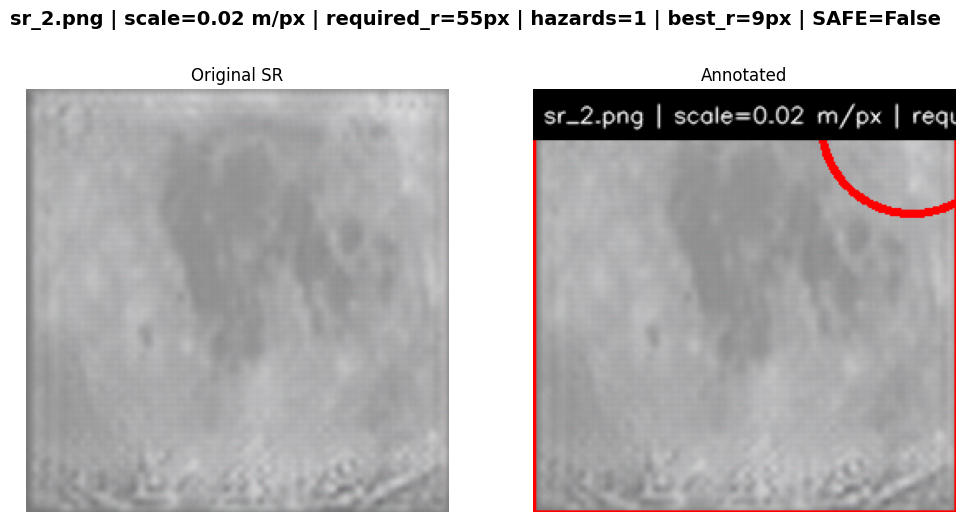

sr_2.png | scale=0.02 m/px | required_r=55px | hazards=1 | best_r=9px | SAFE=False


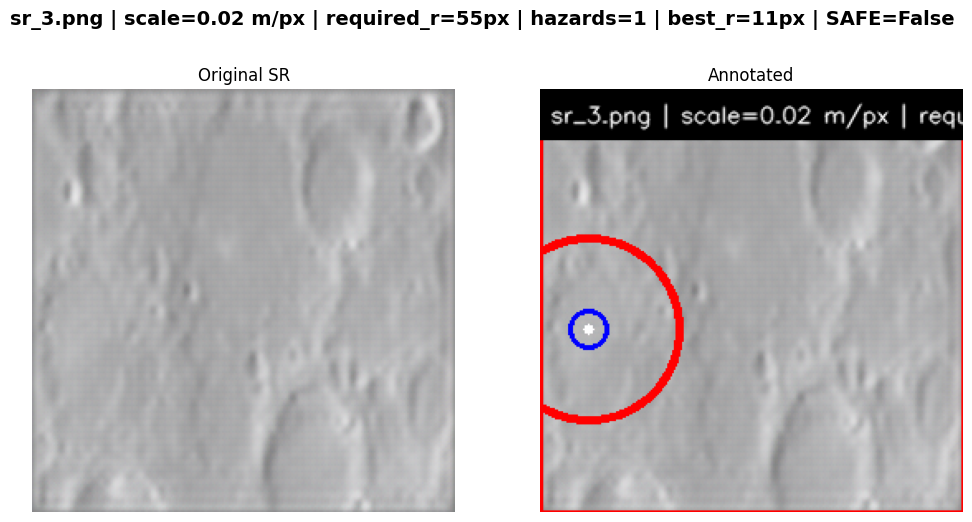

sr_3.png | scale=0.02 m/px | required_r=55px | hazards=1 | best_r=11px | SAFE=False

--- Results using meters_per_pixel = 0.05 m/px -> required_radius = 22 px ---



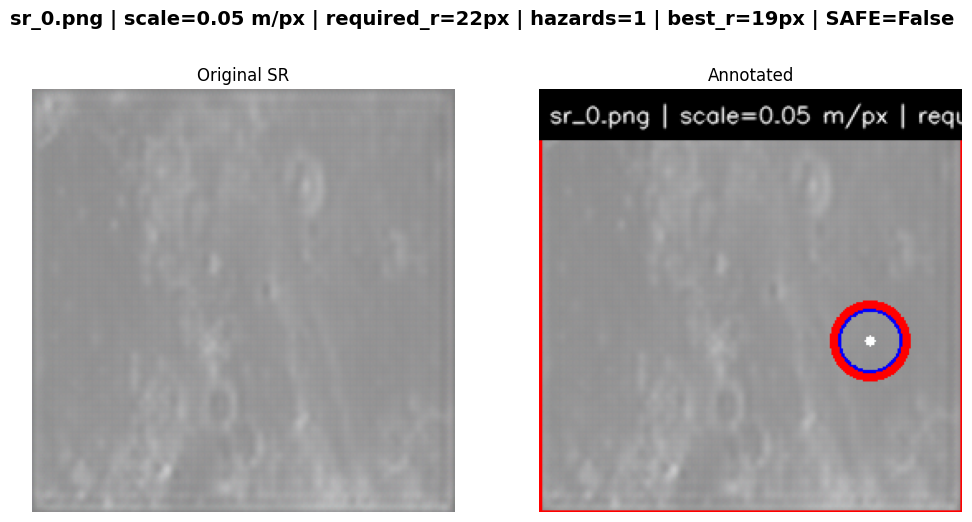

sr_0.png | scale=0.05 m/px | required_r=22px | hazards=1 | best_r=19px | SAFE=False


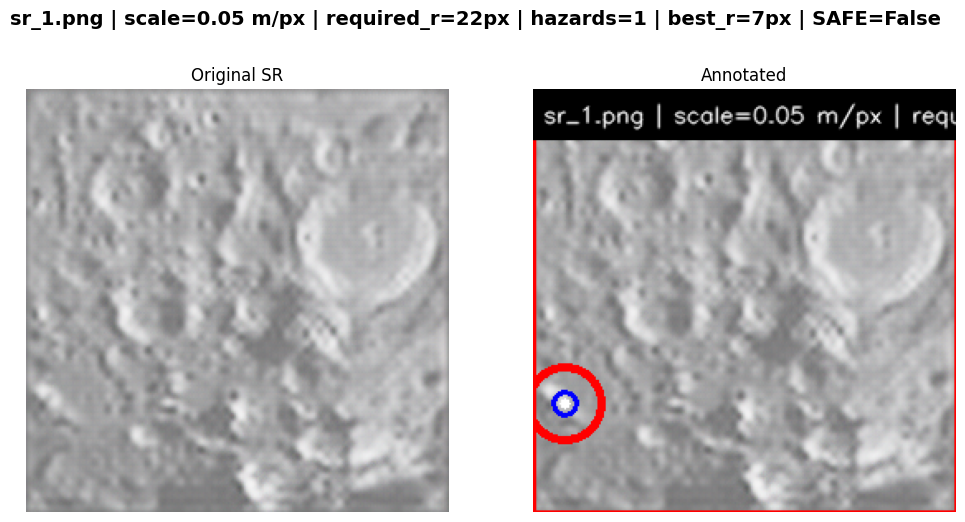

sr_1.png | scale=0.05 m/px | required_r=22px | hazards=1 | best_r=7px | SAFE=False


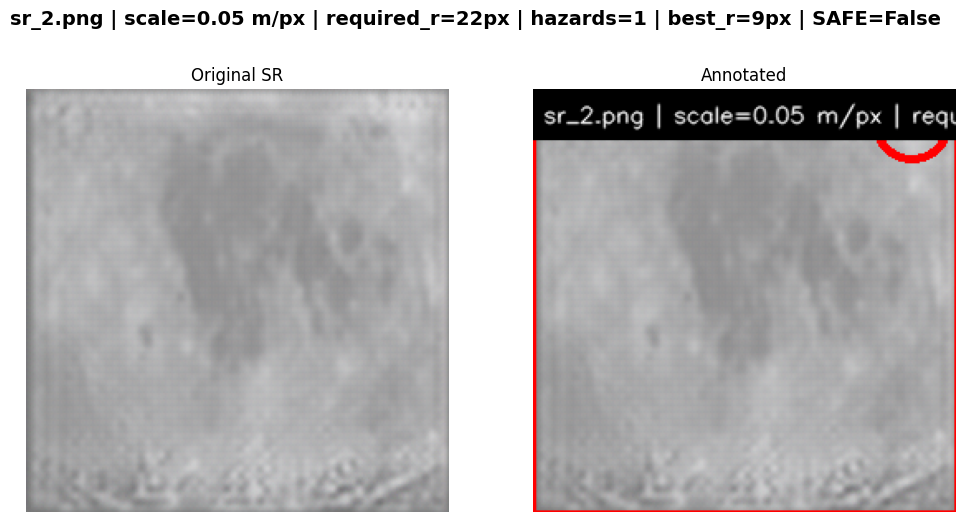

sr_2.png | scale=0.05 m/px | required_r=22px | hazards=1 | best_r=9px | SAFE=False


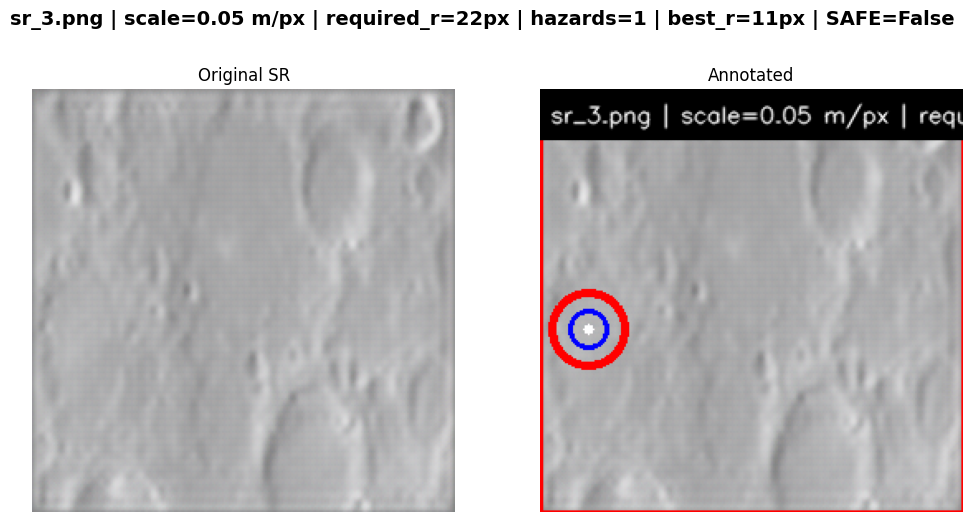

sr_3.png | scale=0.05 m/px | required_r=22px | hazards=1 | best_r=11px | SAFE=False

--- Results using meters_per_pixel = 0.1 m/px -> required_radius = 11 px ---



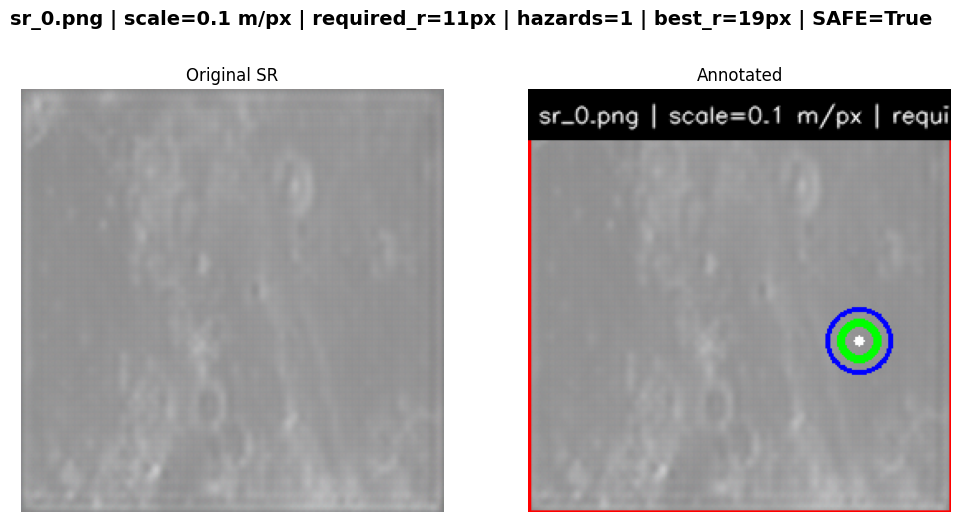

sr_0.png | scale=0.1 m/px | required_r=11px | hazards=1 | best_r=19px | SAFE=True


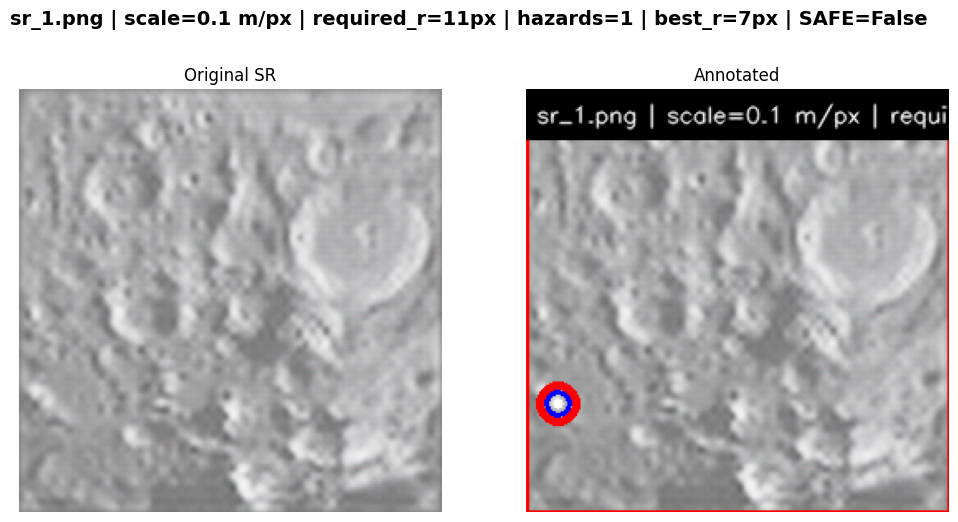

sr_1.png | scale=0.1 m/px | required_r=11px | hazards=1 | best_r=7px | SAFE=False


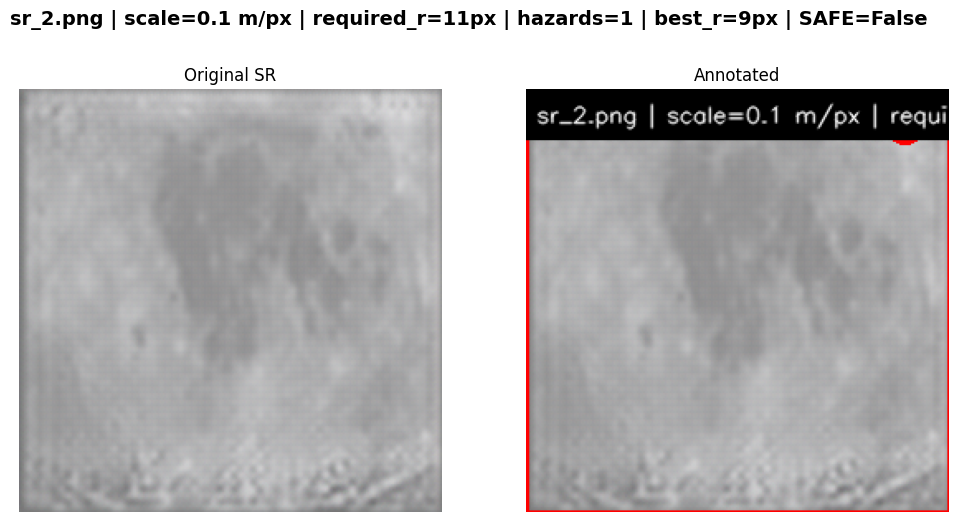

sr_2.png | scale=0.1 m/px | required_r=11px | hazards=1 | best_r=9px | SAFE=False


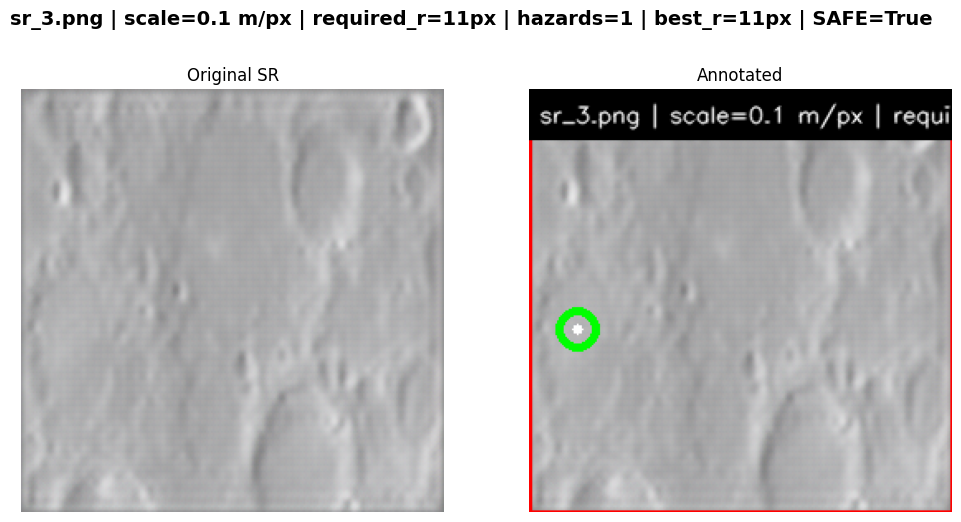

sr_3.png | scale=0.1 m/px | required_r=11px | hazards=1 | best_r=11px | SAFE=True

Done. Annotated outputs saved to: /content/srgan_annotated_landing
CSV summary saved to: /content/srgan_annotated_landing/srgan_landing_summary.csv


In [14]:
# Colab cell: SRGAN outputs -> use Chandrayaan-3 lander radius (1.1 m) -> detect hazards -> recommend landing spot & safety
# Paste & run in Colab. Edit sr_folder or meters_per_pixel if you know it.

import os, cv2, numpy as np, csv
import matplotlib.pyplot as plt
from skimage import morphology, exposure

# ---------- USER SETTINGS ----------
sr_folder = "/content/srgan_outputs"   # folder with SRGAN outputs (change if needed)
out_folder = "/content/srgan_annotated_landing"
os.makedirs(out_folder, exist_ok=True)

# Chandrayaan-3 lander radius w/ 10% margin (meters)
lander_radius_m = 1.1   # 1.0 m nominal radius * 1.1 margin

# If you know meters_per_pixel for your SR images, set it here (float, meters/pixel).
# If unknown, leave as None — the script will try example scales and show results for each.
meters_per_pixel = None   # e.g. 0.05  OR None to try example scales

# example scales to try if meters_per_pixel is None
example_scales = [0.005, 0.01, 0.02, 0.05, 0.1]  # m / pixel

# detection / tuning params (you can change later if detections are noisy)
min_hazard_area = 800
hough_dp = 1.2; hough_minDist = 30; hough_param1 = 100; hough_param2 = 60
hough_minRadius = 8; hough_maxRadius = 80
hough_overlap_iou_thresh = 0.12
border_ignore = 6

# helper: display
def show_pair(orig, ann, header):
    plt.figure(figsize=(12,6))
    plt.suptitle(header, fontsize=14, fontweight='bold')
    plt.subplot(1,2,1); plt.imshow(orig); plt.title("Original SR"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(ann); plt.title("Annotated"); plt.axis('off')
    plt.show()

# hazard detection (contour + Hough filtered)
def detect_hazards(img_bgr):
    h,w = img_bgr.shape[:2]
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_eq = exposure.equalize_adapthist(gray, clip_limit=0.03)
    gray_eq = (gray_eq*255).astype(np.uint8)
    blur = cv2.GaussianBlur(gray_eq, (5,5), 0)

    # contour-based mask
    th = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV,31,9)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    th_closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    th_bool = th_closed.astype(bool)
    th_clean = morphology.remove_small_objects(th_bool, min_size=min_hazard_area)
    mask_contour = (th_clean.astype('uint8')*255)

    # Hough circles for rims
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=hough_dp, minDist=hough_minDist,
                               param1=hough_param1, param2=hough_param2,
                               minRadius=hough_minRadius, maxRadius=hough_maxRadius)
    mask_hough = np.zeros((h,w), dtype=np.uint8)
    if circles is not None:
        circles = np.round(circles[0,:]).astype(int)
        for (cx,cy,r) in circles:
            if r < hough_minRadius or r > hough_maxRadius: continue
            if cx < border_ignore or cy < border_ignore or cx > w-border_ignore or cy > h-border_ignore:
                continue
            circ_mask = np.zeros((h,w), dtype=np.uint8)
            cv2.circle(circ_mask, (cx,cy), max(1, r-2), 255, -1)
            inter = np.logical_and(circ_mask>0, mask_contour>0).sum()
            circ_area = circ_mask.sum() / 255.0
            if circ_area > 0 and (inter / circ_area) >= hough_overlap_iou_thresh:
                cv2.circle(mask_hough, (cx,cy), max(1, r-2), 255, -1)

    combined = cv2.bitwise_or(mask_contour, mask_hough)
    combined = cv2.morphologyEx(combined, cv2.MORPH_CLOSE, kernel, iterations=1)
    comb_bool = combined.astype(bool)
    final_mask = (morphology.remove_small_objects(comb_bool, min_size=min_hazard_area).astype('uint8') * 255)
    return final_mask

# find best landing center and its maximal-fit radius; True if safe for required radius
def find_best_landing(mask, required_r_px):
    h,w = mask.shape[:2]
    if np.sum(mask) == 0:
        return h//2, w//2, min(h//2, w//2), True
    free = (mask == 0).astype(np.uint8)
    dist = cv2.distanceTransform(free, cv2.DIST_L2, 5)
    ys, xs = np.where(dist >= required_r_px)
    if len(ys) > 0:
        idx = np.argmax(dist[ys, xs])
        cy, cx = int(ys[idx]), int(xs[idx])
        return cy, cx, int(dist[cy, cx]), True
    _, maxVal, _, maxLoc = cv2.minMaxLoc(dist)
    cy, cx = int(maxLoc[1]), int(maxLoc[0])
    best_r = int(maxVal)
    best_r = max(1, min(best_r, min(h//2, w//2)))
    return cy, cx, best_r, False

# CSV summary
csv_path = os.path.join(out_folder, "srgan_landing_summary.csv")
csv_fields = ["filename", "scale_m_per_px", "required_r_px", "hazard_count", "best_cx", "best_cy", "best_r_px", "is_safe"]
with open(csv_path, "w", newline="") as cf:
    csv.writer(cf).writerow(csv_fields)

# choose scales to run
scales = [meters_per_pixel] if meters_per_pixel is not None else example_scales

sr_files = sorted([f for f in os.listdir(sr_folder) if f.lower().endswith((".png",".jpg",".jpeg"))])
if len(sr_files) == 0:
    raise SystemExit(f"No SRGAN images in {sr_folder} — run SRGAN eval cell first.")

for scale in scales:
    required_r_px = int(round(lander_radius_m / scale))
    print(f"\n--- Results using meters_per_pixel = {scale} m/px -> required_radius = {required_r_px} px ---\n")
    for fname in sr_files:
        path = os.path.join(sr_folder, fname)
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            print("Cannot read:", path); continue
        h,w = img_bgr.shape[:2]

        mask = detect_hazards(img_bgr)
        contours, _ = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        hazard_count = sum(1 for c in contours if cv2.contourArea(c) >= min_hazard_area)

        cy, cx, best_r_px, is_safe = find_best_landing(mask, required_r_px)

        # Annotate
        out = img_bgr.copy()
        for c in contours:
            if cv2.contourArea(c) < min_hazard_area: continue
            x,y,ww,hh = cv2.boundingRect(c)
            cv2.rectangle(out, (x,y), (x+ww, y+hh), (0,0,255), 2)

        # clamp radius
        br = max(1, min(best_r_px, min(h//2, w//2)))
        req_color = (0,255,0) if is_safe else (0,0,255)

        cv2.circle(out, (cx,cy), br, (255,0,0), 2)              # maximal-fit
        cv2.circle(out, (cx,cy), required_r_px, req_color, 3)  # required lander radius
        cv2.circle(out, (cx,cy), 3, (255,255,255), -1)

        # HEADER text on image
        header = f"{fname} | scale={scale} m/px | required_r={required_r_px}px | hazards={hazard_count} | best_r={br}px | SAFE={is_safe}"
        cv2.rectangle(out, (0,0), (w, 30), (0,0,0), -1)
        cv2.putText(out, header, (6,20), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255,255,255), 1, cv2.LINE_AA)

        # show inside Colab
        show_pair(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB), cv2.cvtColor(out, cv2.COLOR_BGR2RGB), header)
        print(header)

        # append to CSV
        with open(csv_path, "a", newline="") as cf:
            csv.writer(cf).writerow([fname, scale, required_r_px, hazard_count, cx, cy, br, is_safe])

print("\nDone. Annotated outputs saved to:", out_folder)
print("CSV summary saved to:", csv_path)
